In [1]:
import random

import numpy as np

from math import sqrt, log

from GCN import *

In [2]:
### Edge List Implementation

class MaxSetState:
    def __init__(self, data, state = None):
        self.data = data
        self.node_weights = data["x"]
        self.edge_index = data["edge_index"]
        
        # number of total nodes in original graph
        self.num_nodes = len(data["x"])
        if state is None:
            self.state = np.ones(self.num_nodes, dtype=bool)
        else:
            self.state = state
        
    def clone(self):
        return MaxSetState(self.data, self.state.copy())

    def step(self, action):
        assert self.state[action] == 1
        
        edges = self.edge_index.transpose()
        # Get all the neighbors of node action
        removal = edges[edges[:, 0] == action][:, 1]
        
        # Create mask to remove node action and its neighbors
        mask = np.zeros(self.num_nodes, dtype=bool)
        mask[removal] = 1
        mask[action] = 1
        
        # Perform mask
        new_state = self.state & (~mask)
        reward = self.node_weights[action]
        return MaxSetState(self.data, new_state), reward
    
    def getNeighbors(self, node):
        edges = self.edge_index.transpose()
        # Get all the neighbors of node action
        neighbors = edges[edges[:, 0] == node][:, 1]
        return neighbors

    def actions(self):
        return list(np.flatnonzero(self.state))

    def sample_action(self):
        return random.choice(self.actions())

    def get_edgelist(self):
        new_edges = []
        for e in self.edge_index:
            if state[e[0]] == 1 or state[e[1]] == 1:
                new_edges.append(e)
        return np.array(new_edges)

    def score(self):
        assert not self.state.any()
        return 0
    def __repr__(self):
        return str(self.state)


In [3]:
class Node:
    def __init__(self, state: MaxSetState, action = None, parent = None):
        # The action that led to this state, and a reference to the parent
        self.action = action
        self.parentNode = parent

        # Statistics
        self.totalScore = 0
        self.visits = 1

        # Children of node
        self.childNodes = []
        self.untriedActions = state.actions()

    def select_child(self):
        upper_confidence = {c: c.totalScore/c.visits + sqrt(4 * log(self.visits)/c.visits) for c in self.childNodes}
        return max(upper_confidence, key=upper_confidence.get)

    def addChild(self, state, action):
        n = Node(state, action, self)
        self.untriedActions.remove(action)
        self.childNodes.append(n)
        return n

    def update(self, score):
        self.visits += 1
        self.totalScore += score

    def __repr__(self):
        return "[A: {0} S/V: {1:.2f}/{2} AR: {4:.2f} U: {3}]".format(self.action, self.totalScore, self.visits - 1, self.untriedActions, self.totalScore / self.visits)

    def treeToString(self, level = 0):
        s = '\t' * level + "" + str(self) + "\n"
        for c in self.childNodes:
            s += c.treeToString(level + 1)
        return s

In [13]:
def search(root: MaxSetState, itermax, verbose):

    rootnode = Node(root)

    for i in range(itermax):
        if (verbose == 2): print(rootnode.treeToString(0))
        node = rootnode
        state = root.clone()
        # Selection
        while node.untriedActions == [] and node.childNodes != []:
            node = node.select_child()
            state, reward = state.step(node.action)

        # Expansion
        if node.untriedActions != []:
            a = random.choice(node.untriedActions)
            if (verbose == 2):
                print("Taking action: " + str(a))
            state, reward = state.step(a)
            node = node.addChild(state, a)

        # Simulation
        if (verbose == 2):
            print("Starting State: " + str(state))
        score = 0
        while state.actions() != []:
            sampled_action = state.sample_action()
            state, reward = state.step(sampled_action)
            score += reward
            if (verbose == 2):
                print("Simulating Action: " + str(sampled_action))
                print("Simulating Reward: " + str(reward))
                print("Next State: " + str(state))
        # Backpropagate

        while node.action != None:
            score += state.node_weights[node.action]
            node.update(score)
            if (verbose == 2):
                print("Node Weights: " + str(state.node_weights))
                print("Action: " + str(node.action))
                print("Reward Value: " + str(state.node_weights[node.action]))
            node = node.parentNode
        
    if (verbose and verbose != 2): print(rootnode.treeToString(0))

    actions = {c.action: c.visits for c in rootnode.childNodes}
    return sorted(list(actions.keys()), key=actions.get, reverse=True)

In [53]:
import matplotlib.pyplot as plt

visualize = MaxIndDataset('data/weighted_binomial_80')

ID = 4
test_graph = visualize[ID]

Processing...
Done!


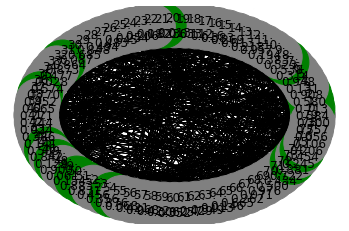

In [54]:
draw_entry(test_graph)

In [55]:
# Debug Search
test_data = {k: np.round(v.data.numpy(), 3) for k, v in iter(test_graph)}
target = sum(test_data['x'][test_data['y'].astype(bool)])
current = MaxSetState(data=test_data)
result = search(current, 10, True)

[A: None S/V: 0.00/0 AR: 0.00 U: [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 52, 53, 54, 55, 56, 57, 58, 59, 60, 63, 64, 65, 67, 69, 70, 72, 73, 74, 75, 77, 78, 79]]
	[A: 71 S/V: 6.62/1 AR: 3.31 U: [0, 1, 2, 3, 4, 9, 11, 12, 13, 15, 17, 18, 19, 20, 21, 25, 26, 27, 28, 29, 31, 32, 33, 34, 37, 38, 42, 43, 45, 47, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 66, 68, 69, 72, 73, 74, 75, 76, 77, 78]]
	[A: 76 S/V: 3.21/1 AR: 1.60 U: [0, 2, 3, 4, 5, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 22, 23, 25, 26, 27, 29, 30, 31, 32, 33, 34, 36, 37, 40, 41, 42, 43, 44, 45, 46, 48, 49, 50, 51, 54, 56, 57, 58, 59, 60, 61, 62, 64, 66, 68, 70, 71, 72, 73, 74, 77, 79]]
	[A: 9 S/V: 5.37/1 AR: 2.69 U: [0, 1, 3, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 30, 31, 32, 33, 34, 35, 36, 38, 39, 41, 42, 43, 45, 46, 48, 49

In [66]:
def random_rollout(data):
    score = 0
    state = MaxSetState(data)
    while state.actions() != []:
        state, reward = state.step(state.sample_action())
        score += reward
    return score

def random_rollout_avg(data, rand_trials):
    tot_rand_score = 0
    for i in range(rand_trials):
        tot_rand_score += random_rollout(data)
    rand_score = tot_rand_score / rand_trials
    return rand_score

def random_rollout_max(data, rand_trials):
    max_rand_score = 0
    for i in range(rand_trials):
        max_rand_score = max(max_rand_score, random_rollout(data))
    return max_rand_score

In [69]:
for ID in range(20):
    test_graph = visualize[ID]
    tot_score = 0
    max_tot_score = 0
    trials = 5
    
    test_data = {k: np.round(v.data.numpy(), 3) for k, v in iter(test_graph)}

    target = sum(test_data['x'][test_data['y'].astype(bool)])
    for i in range(trials):
        current = MaxSetState(data=test_data)
        score = 0
        action = "None"
        reward = 0
        chosen = []
        while current.actions() != []:
            result = search(current, 1000, False)
            current, r = current.step(result[0])
            # print("Action: {0} Reward: {1:.3f} Results: {2}".format(action, reward, result))
            action = result[0]
            score += r
            reward = r
            chosen.append(action)
        tot_score += score

        optimal = np.flatnonzero(test_data['y'])
#         print("Chosen: {0}".format(sorted(chosen)))
#         print("Optimal: {0}".format(sorted(optimal)))
#         print("Action: {0} Score: {1:.3f}".format(action, score))
#         print("Target: {0:.3f}".format(target))
#         print("--------------------")
        max_tot_score = max(max_tot_score, score)
    rand_avg_baseline = random_rollout_avg(test_data, 1000)
    rand_max_baseline = random_rollout_max(test_data, 1000)
    print("ID[{0}]: Target: {1:.3f} Algo Avg Score: {2:.3f}\t Algo Max Score: {3:.3f}\t Rand Avg Score: {4:.3f} Rand Max Score: {5:.3f}".format(ID, target, (tot_score / trials), max_tot_score, rand_avg_baseline, rand_max_baseline))

ID[0]: Target: 11.003 Algo Avg Score: 9.822	 Algo Max Score: 10.140	 Rand Avg Score: 6.761 Rand Max Score: 9.802
ID[1]: Target: 11.145 Algo Avg Score: 10.528	 Algo Max Score: 10.921	 Rand Avg Score: 7.125 Rand Max Score: 10.594
ID[2]: Target: 10.300 Algo Avg Score: 9.416	 Algo Max Score: 10.031	 Rand Avg Score: 6.090 Rand Max Score: 9.751
ID[3]: Target: 10.710 Algo Avg Score: 8.860	 Algo Max Score: 9.718	 Rand Avg Score: 5.850 Rand Max Score: 10.526
ID[4]: Target: 10.230 Algo Avg Score: 9.321	 Algo Max Score: 9.682	 Rand Avg Score: 5.732 Rand Max Score: 9.617
ID[5]: Target: 13.728 Algo Avg Score: 11.926	 Algo Max Score: 13.002	 Rand Avg Score: 7.514 Rand Max Score: 12.318
ID[6]: Target: 12.275 Algo Avg Score: 11.450	 Algo Max Score: 12.211	 Rand Avg Score: 6.619 Rand Max Score: 12.211
ID[7]: Target: 12.003 Algo Avg Score: 11.009	 Algo Max Score: 12.003	 Rand Avg Score: 7.017 Rand Max Score: 10.969
ID[8]: Target: 11.036 Algo Avg Score: 10.186	 Algo Max Score: 11.036	 Rand Avg Score: 6.6

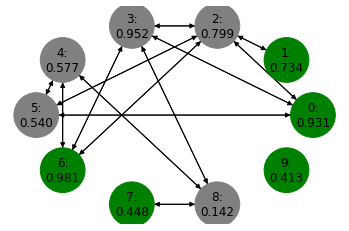

In [38]:
draw_entry(test_graph)

In [ ]:
current = MaxSetState(data=test_data)

In [ ]:
current.getNeighbors(16)